# Evaluating variation in model predictions and predicted 10k thrombolysis rate using bootstrap models

## Plain English summary
Here we evaluate the variation in model predictions (at a patient level) and predicted 10k thrombolysis rate using bootstrap models.

We apply two bootstrap methods. In the traditional method we fit multiple models to bootstrapped samples of the training set (random sampling with replacement).

In the Bayesian bootstrap method we fit multiple models, with the training set weighted each time by sampling from a Dirichlet distribution (see https://towardsdatascience.com/the-bayesian-bootstrap-6ca4a1d45148).

These methods give similar results - the average standard deviation in patient-level prediction (the probability of a patient receiving thrombolysis) is about 0.05, but this ranges from about 0.01 to 0.13 depending on the predicted probability (with greatest variance around 50% predicted probability of receiving thrombolysis). The average standard deviation in predicting the hospital's expected thrombolysis rate is 0.015 - 0.02.

## Model and data

The XGBoost model is trained on bootstrapped datasets created from all but 10k instances to predict which patient will recieve thrombolysis. It uses 10 features:
* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 10 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims
* Fit XGBoost model to the 10k cohort data (individual division of data between train and test set)
* Traditional bootstrapping method: 
    * Fit 30 XGBoost models to the 10k cohort data (recreate the training set 30 times by sampling with replacement from the training set. Test set same for each). 
    * Get thrombolysis rate for each hospital for the 10k cohort (test set) for each of the 30 models trained on the 30 different training sets.
* Baysian bootstrapping method:
    * Fit 30 XGBoost models to the 10k cohort data with the training set weighted each time by sampling from a Dirichlet distribution
    * Get thrombolysis rate for each hospital for the 10k cohort (test set) for each of the 30 models trained on the 30 different weighted training sets.
* Analyse the variation in hospital thrombolysis rate on the 10k cohort test set from each set of bootstrapped models

## Observations
* 

## Import packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier
import json

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features_10k_cohort'
notebook = '50'

## Create bootstrap sampled training sets using standard bootstrapping

## Read in JSON file

Contains a dictionary for plain English feature names for the 10 features selected in the model. Use these as the column titles in the DataFrame.

In [3]:
with open("./output/01_feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [4]:
data_loc = '../data/10k_training_test/'

In [5]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=feature_name_dict, inplace=True)
test = test[key_features]
test.rename(columns=feature_name_dict, inplace=True)

## Train XGBoost model using normal (non bootstrapping) method

In [6]:
# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)  

# Define and fit model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.848


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [7]:
# Get list of hospitals
hospitals = list(set(train['Stroke team']))
hospitals.sort()

# Initialise list
single_fit_thrombolysis_10k_rate = []

# Through each hospital
for hospital in hospitals:

    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1

    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
            
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    
    # Store predictions for hospital in list
    single_fit_thrombolysis_10k_rate.append(y_pred.mean())

## Create bootstrap sampled training sets using standard bootstrapping
Define number of splits

In [8]:
splits = 30

Store the data splits in a list (recreate the training set 30 times by sampling with replacement from the training set)

In [9]:
# Initialise list
train_set = []

# Store data splits in a list
for i in range(splits):
    train_set.append(train.sample(frac=1, replace=True))

## Train models

In [10]:
# Initialise lists
models = []
all_predictions = []

# For each split
for i in range(splits):

    # Get X and y
    X_train = train_set[i].drop('Thrombolysis', axis=1)
    X_test = test.drop('Thrombolysis', axis=1)
    y_train = train_set[i]['Thrombolysis']
    y_test = test['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)    

    # Define model
    model = XGBClassifier(verbosity=0, seed=42+i, learning_rate=0.5)

    # Fit model
    model.fit(X_train, y_train)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    all_predictions.append(y_probs)
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Accuracy set {i}: {accuracy:.3f}')

Accuracy set 0: 0.844
Accuracy set 1: 0.840
Accuracy set 2: 0.839
Accuracy set 3: 0.841
Accuracy set 4: 0.842
Accuracy set 5: 0.841
Accuracy set 6: 0.844
Accuracy set 7: 0.844
Accuracy set 8: 0.844
Accuracy set 9: 0.846
Accuracy set 10: 0.845
Accuracy set 11: 0.843
Accuracy set 12: 0.844
Accuracy set 13: 0.842
Accuracy set 14: 0.845
Accuracy set 15: 0.841
Accuracy set 16: 0.841
Accuracy set 17: 0.848
Accuracy set 18: 0.843
Accuracy set 19: 0.844
Accuracy set 20: 0.841
Accuracy set 21: 0.845
Accuracy set 22: 0.843
Accuracy set 23: 0.840
Accuracy set 24: 0.844
Accuracy set 25: 0.842
Accuracy set 26: 0.844
Accuracy set 27: 0.841
Accuracy set 28: 0.843
Accuracy set 29: 0.839


Calculate mean standard deviation of bootstrap replicates for individual patient predictions.

In [11]:
all_predictions = np.array(all_predictions)
prediction_mean = all_predictions.mean(axis=0)
prediction_std = all_predictions.std(axis=0)
mean_std = prediction_std.mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.057


Show relationship between probability of receiving thrombolysis, and variation in predicted probability over bootstrapped models.

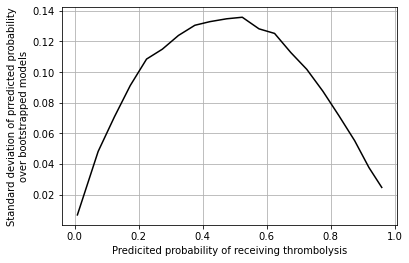

In [12]:
# Set up data frame of results
patient_predictions = pd.DataFrame()
patient_predictions['mean_prob'] = prediction_mean
patient_predictions['std_prob'] = prediction_std
# Bin mean probability of receiving thrombolysis
patient_predictions['bin'] = np.digitize(prediction_mean, 
                                         bins = np.arange(0, 1.1, 0.05))
# Calculate mean results by bin
pivot = patient_predictions.groupby('bin').mean()

# Plot
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(pivot['mean_prob'], pivot['std_prob'], c='k')
ax.grid()
ax.set_xlabel('Predicited probability of receiving thrombolysis')
ax.set_ylabel('Standard deviation of prredicted probability\nover bootstrapped '
              'models')
plt.savefig(f'./output/{notebook}_{model_text}_bootstrap_prediction_sd.jpg', 
            dpi=300)
plt.show()


### Pass 10k cohort through all hospital models and get thrombolysis rate (for each split)

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining. Repeat for each model trained on a different training set (sampling with replacement from the training set).

In [13]:
# Set up lists for split results
split_thrombolysis_10k_rates = []
split_individual_results = []

# For each split
for i in range(splits):

    # Initalise lists
    thrombolysis_rate = []
    single_predictions = []

    # For each hospital
    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe & change hospital ID (after setting all to 
        #   zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
                
        # Get predicted probabilities and class
        y_probs = models[i].predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
        
        # Save predictions
        single_predictions.append(y_pred * 1)
    
    # Convert individual predictions (a list of arrays) to a NumPy array, and 
    #   transpose
    patient_results = np.array(single_predictions).T

    # Convert to DataFrame
    patient_results = pd.DataFrame(patient_results)
    split_individual_results.append(patient_results)

    # Get thrombolysis rate
    thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
    thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
    
    # Add to list
    split_thrombolysis_10k_rates.append(thrombolysis_by_hosp)

Concatenate results from list into a dataframe. Contains thrombolysis rate for each hospital for each split of data (row per hospital, column per model trained on a different training set).

In [14]:
split_thrombolysis_10k_rates = pd.concat(split_thrombolysis_10k_rates,axis=1)
split_thrombolysis_10k_rates.head()

,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,...,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate
AGNOF1041H,0.3137,0.3232,0.2913,0.3228,0.3235,0.2823,0.2784,0.3566,0.3045,0.2885,...,0.2934,0.3104,0.2803,0.2968,0.2985,0.2935,0.2445,0.2699,0.2861,0.3167
AKCGO9726K,0.3521,0.3402,0.3447,0.3409,0.3472,0.3182,0.3364,0.3481,0.3327,0.3600,...,0.3143,0.3649,0.3351,0.3101,0.3232,0.3408,0.3286,0.3445,0.3415,0.3537
AOBTM3098N,0.2333,0.2323,0.2342,0.2316,0.2354,0.2752,0.2542,0.2271,0.2190,0.2562,...,0.2384,0.2225,0.2507,0.2098,0.2219,0.2659,0.2640,0.2539,0.2473,0.2213
APXEE8191H,0.2927,0.2793,0.2730,0.2689,0.2894,0.2776,0.3026,0.2897,0.2761,0.2606,...,0.3109,0.2772,0.2740,0.2602,0.2766,0.2869,0.2901,0.2762,0.2908,0.2634
ATDID5461S,0.3104,0.3039,0.3329,0.3031,0.2983,0.3311,0.2977,0.3167,0.3355,0.3157,...,0.2915,0.3298,0.3096,0.3079,0.3401,0.3064,0.2995,0.3022,0.3013,0.2831


In [15]:
summary = split_thrombolysis_10k_rates.T.describe()
summary = summary.T
summary['single fit'] = single_fit_thrombolysis_10k_rate

# Add confidence limits
alpha = 0.95
length = len(split_thrombolysis_10k_rates)
loc = split_thrombolysis_10k_rates.mean(axis=1)
scale = split_thrombolysis_10k_rates.std(axis=1)
confidence = stats.t.interval(alpha, length, loc, scale)
summary['lower 95'] = loc - confidence[0]
summary['upper 95'] = confidence[1] - loc
summary['std'] = scale
summary

,count,mean,std,min,25%,50%,75%,max,single fit,lower 95,upper 95
AGNOF1041H,30.0,0.299270,0.021810,0.2445,0.286925,0.29640,0.313625,0.3566,0.3088,0.043142,0.043142
AKCGO9726K,30.0,0.337163,0.015830,0.2970,0.328875,0.34050,0.347150,0.3649,0.3394,0.031314,0.031314
AOBTM3098N,30.0,0.238263,0.017606,0.2026,0.226725,0.23480,0.253100,0.2752,0.2372,0.034827,0.034827
APXEE8191H,30.0,0.282070,0.015963,0.2364,0.275575,0.27845,0.290625,0.3109,0.2897,0.031576,0.031576
ATDID5461S,30.0,0.310547,0.016714,0.2831,0.299950,0.30565,0.316450,0.3459,0.3084,0.033062,0.033062
...,...,...,...,...,...,...,...,...,...,...,...
YPKYH1768F,30.0,0.265033,0.022752,0.2025,0.256000,0.26715,0.281150,0.3248,0.2624,0.045006,0.045006
YQMZV4284N,30.0,0.335557,0.015098,0.3063,0.324725,0.33310,0.346025,0.3704,0.3424,0.029864,0.029864
ZBVSO0975W,30.0,0.211757,0.024628,0.1555,0.196325,0.20930,0.228050,0.2610,0.2126,0.048716,0.048716
ZHCLE1578P,30.0,0.301927,0.011186,0.2680,0.295250,0.30165,0.307100,0.3222,0.3029,0.022127,0.022127


Identify hospital order in ascending 10k thrombolysis rate

In [16]:
order = list(summary.sort_values('single fit').index)
order[:5]

['XPABC1435F', 'HZMLX7970T', 'OUXUZ1084Q', 'LGNPK4211W', 'LECHF1024T']

Calculate mean standard deviation of bootstrap replicates for 10k thrombolysis rates.

In [17]:
mean_std = summary['std'].mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.018


meanPlot boxplot

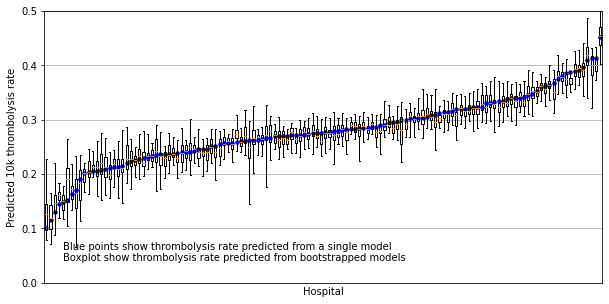

In [18]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1
ax.scatter(x, single_fit_values, c='b', s=12)
ax.boxplot(split_thrombolysis_10k_rates.loc[order].T, whis=999)
ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
text = ('Blue points show thrombolysis rate predicted from a single model\n'
        'Boxplot show thrombolysis rate predicted from bootstrapped models')
ax.text(5, 0.04, text)
ax.grid()
plt.show()

Plot mean and standard deviation

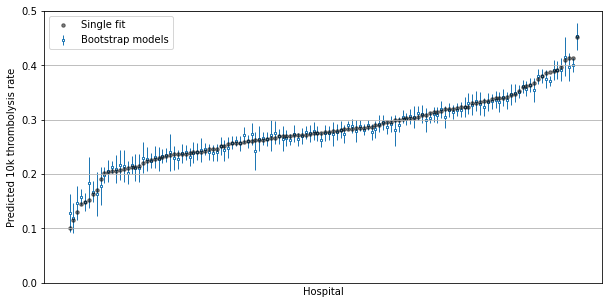

In [19]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1

ax.errorbar(x, 
    summary.loc[order]['mean'], 
    yerr=(summary.loc[order]['std']),
    lw=1, ls='', marker='s', markersize=2.5, mfc='w',
    label='Bootstrap models',
    zorder=0)

ax.scatter(x, single_fit_values, c='k', s=12, alpha=0.5, label='Single fit', 
           zorder=1)

ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
ax.legend()
ax.grid()
plt.savefig(f'./output/{notebook}_{model_text}_bootstrap_10k_sd.jpg', dpi=300)
plt.show()

## Create bootstrap sampled training sets using Bayesian bootstrapping

See: https://towardsdatascience.com/the-bayesian-bootstrap-6ca4a1d45148

In [20]:
N = len(train)

# Initialise lists
models = []
all_predictions = []

# For each split
for i in range(splits):

    # Get weights
    bayesian_weights = np.random.dirichlet(alpha=np.ones(N)*1, size=1)[0] * N

    # Get X and y
    X_train = train.drop('Thrombolysis', axis=1)
    X_test = test.drop('Thrombolysis', axis=1)
    y_train = train['Thrombolysis']
    y_test = test['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)  

    # Define and fit model
    model = XGBClassifier(verbosity=0, seed=42+i, learning_rate=0.5)
    model.fit(X_train, y_train, sample_weight=bayesian_weights)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    all_predictions.append(y_probs)
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Accuracy set {i}: {accuracy:.3f}')

Accuracy set 0: 0.844
Accuracy set 1: 0.844
Accuracy set 2: 0.846
Accuracy set 3: 0.846
Accuracy set 4: 0.840
Accuracy set 5: 0.843
Accuracy set 6: 0.841
Accuracy set 7: 0.845
Accuracy set 8: 0.841
Accuracy set 9: 0.841
Accuracy set 10: 0.844
Accuracy set 11: 0.842
Accuracy set 12: 0.843
Accuracy set 13: 0.841
Accuracy set 14: 0.845
Accuracy set 15: 0.844
Accuracy set 16: 0.841
Accuracy set 17: 0.845
Accuracy set 18: 0.842
Accuracy set 19: 0.845
Accuracy set 20: 0.842
Accuracy set 21: 0.841
Accuracy set 22: 0.843
Accuracy set 23: 0.841
Accuracy set 24: 0.845
Accuracy set 25: 0.839
Accuracy set 26: 0.844
Accuracy set 27: 0.844
Accuracy set 28: 0.842
Accuracy set 29: 0.843


Calculate mean standard deviation of bootstrap replicates for individual patient predictions.

In [21]:
all_predictions = np.array(all_predictions)
prediction_std = all_predictions.std(axis=0)
mean_std = prediction_std.mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.054


Show relationship between probability of receiving thrombolysis, and variation in predicted probability over bootstrapped models.

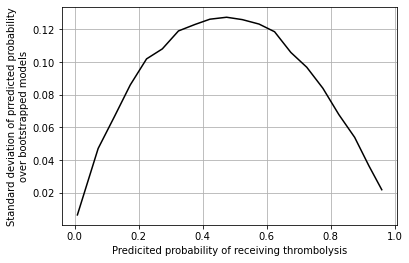

In [22]:
# Set up data frame of results
patient_predictions = pd.DataFrame()
patient_predictions['mean_prob'] = prediction_mean
patient_predictions['std_prob'] = prediction_std
# Bin mean probability of receiving thrombolysis
patient_predictions['bin'] = np.digitize(prediction_mean, 
                                         bins=np.arange(0, 1.1, 0.05))
# Calculate mean results by bin
pivot = patient_predictions.groupby('bin').mean()

# Plot
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(pivot['mean_prob'], pivot['std_prob'], c='k')
ax.grid()
ax.set_xlabel('Predicited probability of receiving thrombolysis')
ax.set_ylabel('Standard deviation of prredicted probability\n'
              'over bootstrapped models')
plt.savefig(f'./output/{notebook}_{model_text}_bayesian_bootstrap_prediction_'
            f'sd.jpg', dpi=300)
plt.show()


### Pass 10k cohort through all hospital models and get thrombolysis rate (for each bootstrap)

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining. Repeat for each model trained on the training dataset using different weights.

In [23]:
# Set up lists for split results
split_thrombolysis_10k_rates = []
split_individual_results = []

# For each split
for i in range(splits):

    # Initialise lists
    thrombolysis_rate = []
    single_predictions = []

    # For each hospital
    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to
        #   zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
                
        # Get predicted probabilities and class
        y_probs = models[i].predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
        
        # Save predictions
        single_predictions.append(y_pred * 1)
    
    # Convert individual predictions (a list of arrays) to a NumPy array, and 
    #   transpose
    patient_results = np.array(single_predictions).T
    # Convert to DataFrame
    patient_results = pd.DataFrame(patient_results)
    split_individual_results.append(patient_results)

    # Get thrombolysis rate
    thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
    thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
    split_thrombolysis_10k_rates.append(thrombolysis_by_hosp)

Concatenate results from list into a dataframe. Contains thrombolysis rate for each hospital for each split of data (row per hospital, column per model trained on a training set using different weights).

In [24]:
split_thrombolysis_10k_rates = pd.concat(split_thrombolysis_10k_rates,axis=1)
split_thrombolysis_10k_rates.head()

,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,...,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate
AGNOF1041H,0.3079,0.3336,0.3354,0.3257,0.3173,0.3060,0.2899,0.2896,0.2639,0.3034,...,0.3237,0.3147,0.2938,0.3156,0.3011,0.3364,0.2842,0.2968,0.3201,0.2867
AKCGO9726K,0.3404,0.3776,0.3383,0.3383,0.3331,0.3475,0.3333,0.3318,0.3167,0.3390,...,0.3462,0.3386,0.3430,0.3498,0.3251,0.3548,0.3263,0.3280,0.3344,0.3295
AOBTM3098N,0.2383,0.2516,0.2680,0.2539,0.2729,0.2355,0.2435,0.2537,0.2163,0.2174,...,0.2440,0.2343,0.2296,0.2704,0.2112,0.2460,0.2427,0.2257,0.2363,0.1996
APXEE8191H,0.2865,0.2859,0.2888,0.2875,0.2851,0.3018,0.2951,0.2870,0.3085,0.2756,...,0.3128,0.2704,0.2786,0.3051,0.2718,0.2975,0.2910,0.2814,0.2992,0.2746
ATDID5461S,0.3034,0.3138,0.2965,0.2963,0.3129,0.3291,0.3297,0.3232,0.3104,0.2691,...,0.3336,0.2984,0.3337,0.3116,0.2952,0.2945,0.2794,0.3045,0.2950,0.3224


In [25]:
summary = split_thrombolysis_10k_rates.T.describe()
summary = summary.T
summary['single fit'] = single_fit_thrombolysis_10k_rate

# Add confidence limits
alpha = 0.95
length = len(split_thrombolysis_10k_rates)
loc = split_thrombolysis_10k_rates.mean(axis=1)
scale = split_thrombolysis_10k_rates.std(axis=1)
confidence = stats.t.interval(alpha, length, loc, scale)
summary['lower 95'] = loc - confidence[0]
summary['upper 95'] = confidence[1] - loc
summary['std'] = scale
summary

,count,mean,std,min,25%,50%,75%,max,single fit,lower 95,upper 95
AGNOF1041H,30.0,0.302580,0.018763,0.2639,0.290875,0.30040,0.315425,0.3364,0.3088,0.037116,0.037116
AKCGO9726K,30.0,0.336957,0.013063,0.3167,0.329625,0.33385,0.340300,0.3776,0.3394,0.025840,0.025840
AOBTM3098N,30.0,0.239627,0.017642,0.1996,0.229750,0.24005,0.250900,0.2729,0.2372,0.034897,0.034897
APXEE8191H,30.0,0.286547,0.012427,0.2542,0.279175,0.28675,0.292625,0.3128,0.2897,0.024582,0.024582
ATDID5461S,30.0,0.308640,0.018811,0.2691,0.295350,0.30940,0.323000,0.3405,0.3084,0.037209,0.037209
...,...,...,...,...,...,...,...,...,...,...,...
YPKYH1768F,30.0,0.259573,0.016339,0.2379,0.246550,0.25645,0.269125,0.2996,0.2624,0.032320,0.032320
YQMZV4284N,30.0,0.341143,0.015051,0.3159,0.333125,0.34030,0.349675,0.3725,0.3424,0.029772,0.029772
ZBVSO0975W,30.0,0.201877,0.028476,0.1411,0.188475,0.20395,0.215075,0.2528,0.2126,0.056329,0.056329
ZHCLE1578P,30.0,0.299087,0.011415,0.2787,0.289625,0.29870,0.304925,0.3242,0.3029,0.022579,0.022579


Identify hospital order in ascending 10k thrombolysis rate

In [26]:
order = list(summary.sort_values('single fit').index)
order[:5]

['XPABC1435F', 'HZMLX7970T', 'OUXUZ1084Q', 'LGNPK4211W', 'LECHF1024T']

Calculate mean standard deviation of bootstrap replicates for 10k thrombolysis rates.

In [27]:
mean_std = summary['std'].mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.016


Plot boxplot

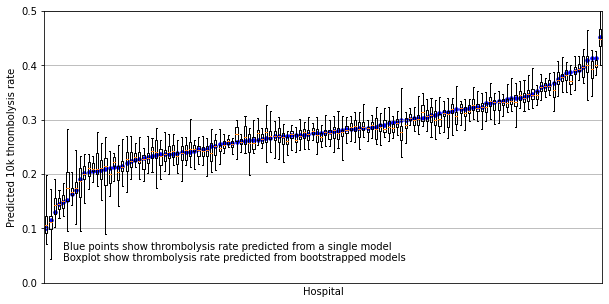

In [28]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1
ax.scatter(x, single_fit_values, c='b', s=12)
ax.boxplot(split_thrombolysis_10k_rates.loc[order].T, whis=999)
ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
text = ('Blue points show thrombolysis rate predicted from a single model\n'
        'Boxplot show thrombolysis rate predicted from bootstrapped models')
ax.text(5, 0.04, text)
ax.grid()
plt.show()

Plot mean and standard deviation

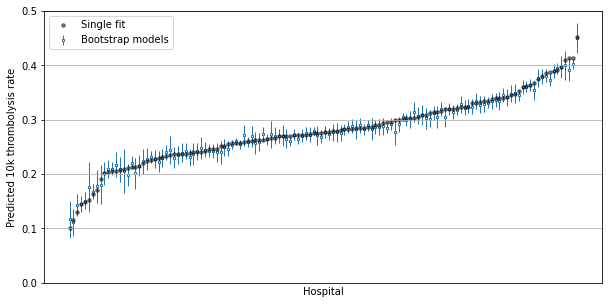

In [29]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1

ax.errorbar(x, 
    summary.loc[order]['mean'], 
    yerr=(summary.loc[order]['std']),
    lw=1, ls='', marker='s', markersize=2.5, mfc='w',
    label='Bootstrap models',
    zorder=0)

ax.scatter(x, single_fit_values, c='k', s=12, alpha=0.5, label='Single fit', 
           zorder=1)

ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
ax.legend()
ax.grid()
plt.savefig(f'./output/{notebook}_{model_text}_bayesian_bootstrap_10k_sd.jpg', 
            dpi=300)
plt.show()